This notebook collects some basic examples of the usage and conventions used in the `spinsfast` package.  That [package](http://astrophysics.physics.fsu.edu/~huffenbe/research/spinsfast/index.html) was originally created by Huffenberger and Wandelt, which is based on [their paper](http://iopscience.iop.org/0067-0049/189/2/255).  But this notebook uses [the version of the code that I've made](https://github.com/moble/spinsfast), based on their work -- though I don't expect it makes any difference.

If you wish to use this notebook, you'll need to ensure that `spinsfast` is installed as a python module.  In particular, you should be able to execute the following cell:

In [1]:
import spinsfast

In the `spinsfast` code directory, we find `example/example_spin.py`, which will guide much of what we do here.  We will also reproduce it here.

The following are some basic imports we will use.  Note that the `spherical_functions` package is available [here](https://github.com/moble/spherical_functions).

In [2]:
%pylab inline
import math
import cmath
import numpy as np
import quaternion
import spherical_functions as sf

Populating the interactive namespace from numpy and matplotlib


# $\theta$, $\phi$ ordering conventions

Evidently, the conventions for the *meaning* of $\theta$ and $\phi$ are the usual respectable ones.  That is, $\theta$ is the polar spherical coordinate ranging from $0$ at the north pole to $\pi$ at the south pole; $\phi$ is the azimuthal angle starting at $0$ on the $x$ axis, and increasing to $2\pi$.

So the real question is just how these things are stored.  There's a comment in `example_spin.py` saying
```python
# In this pixelization, access the map with f[itheta,iphi]
# where 0 <= itheta <= Ntheta-1 and 0<= iphi <= Nphi-1
# and theta = pi*itheta/(Ntheta-1) phi = 2*pi*iphi/Nphi
```
We can create an array of $(\theta, \phi)$ values, and test that it satisfies these properties.

In [3]:
ell_max = 8
n_theta = 2*ell_max+1
n_phi = 2*ell_max+1

theta_phi = np.array([[[theta, phi]
                       for phi in np.linspace(0.0, 2*np.pi, num=n_phi, endpoint=False)]
                      for theta in np.linspace(0.0, np.pi, num=n_theta, endpoint=True)])

for itheta in range(n_theta):
    for iphi in range(n_phi):
        assert np.allclose(theta_phi[itheta, iphi], np.array([itheta*np.pi/(n_theta-1), iphi*2*np.pi/n_phi]), rtol=1e-15, atol=0.0)

So the `theta_phi` array seems to have been properly constructed and indexed.  In the future, we can just replace `[theta, phi]` with whatever function of $(\theta, \phi)$ we need.

# $(\ell,m)$ ordering conventions

N.B.: Modes for `spinsfast` are always stored beginning with $(\ell,m) = (0,0)$, even for spin-weighted fields $s \neq 0$.

The order of the modes is consistent with the following nested loops (as seen in `example_spin.py`):

```python
for l in range(abs(s),lmax+1) :
    for m in range(-l,l+1) :
```

This ordering is shared by my `spherical_functions` package, where we find a few utility functions to convert between the array index and the $(\ell,m)$ values.

To demonstrate this, we first create an array containing the $(\ell,m)$ modes in the right order:

In [4]:
lm = [[ell,m] for ell in range(0,ell_max+1) for m in range(-ell,ell+1)]

Now, we can use the `spherical_functions` function `LM_index(ell, m, ell_min)` to find the correct array index, given any `(ell, m)` value.  Note that this function does not assume the array starts with 0, so we'll always have to pass the `ell_min=0` parameter.  We check that the `lm` array has the expected values:

In [5]:
for ell in range(0,ell_max+1):
    for m in range(-ell,ell+1):
        assert lm[sf.LM_index(ell,m,0)] == [ell,m]

We also have a `spherical_functions` member `LM_range(ell_min, ell_max)` to construct the LM values as given more explicitly above.  Again, we'll always have to pass in `ell_min=0` for `spinsfast` compatibility.

In [6]:
lm2 = sf.LM_range(0, 8)
assert np.all(lm2 == lm)  # Test that this version is identical to the one above

# `example_spin`

The following is copied from the `example_spin.py` file, with some extra comments from me.  Basically, this produces random modes, converts to physical space (the value of the function on a grid), and then converts back to modes.  We can see that the conversion process gives us a tiny error in the modes, by comparing the mode values before and after the transformations.  I've also added an additional step that subtracts the modes, then converts that back to physical space and plots it.

max(abs(alm2-alm)) = 6.34986487898e-14
max(abs(alm)) = 2.67470628819


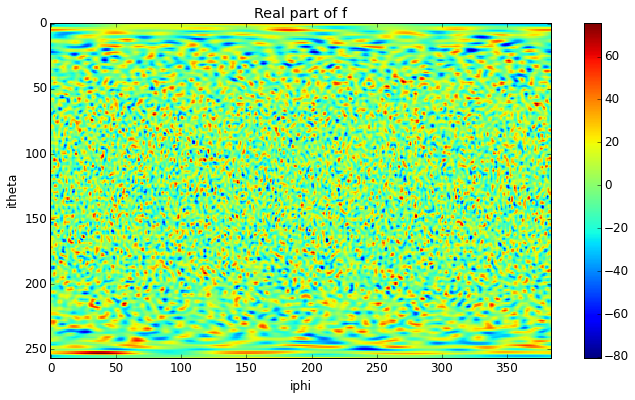

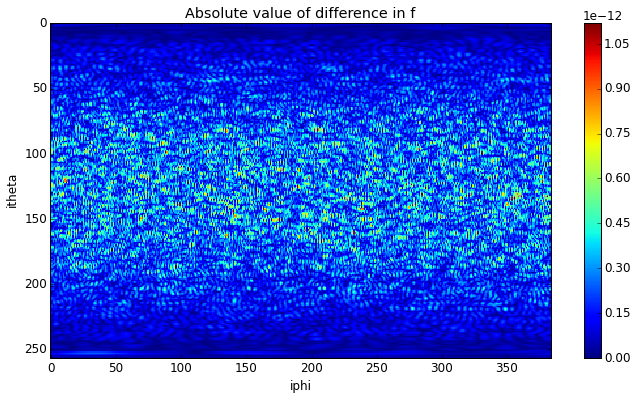

In [7]:
from numpy import zeros, complex
from numpy.random import normal,seed

import spinsfast

s = 1  # spin weight of the field
lmax = 127  # maximum ell value used
Ntheta = 257  # Note that this is greater than 2*lmax+1, and is of the form 2**n+1
Nphi = 384  # Note that this is greater than 2*lmax+1, but NOT of the form 2**n+1

# lmax = 8
# Ntheta = 2*lmax+1
# Nphi = 2*lmax+1

Nlm = spinsfast.N_lm(lmax);  # Total number of complex components of the mode decomposition
alm = zeros(Nlm,dtype=complex)  # Holds the a_{ell,m} mode components

seed(3124432)  # Seed the random-number generator, for reproducibility
for l in range(abs(s),lmax+1) :  # Only fill in nonzero values for ell >= abs(s)
    for m in range(-l,l+1) :
        i = spinsfast.lm_ind(l,m,lmax)
        if (m==0) :
            alm[i] = normal()  # I don't understand why they want this to be real...
        else :
            alm[i] = normal()/2 + 1j*normal()/2

f =  spinsfast.salm2map(alm,s,lmax,Ntheta,Nphi)

alm2 = spinsfast.map2salm(f,s,lmax)

diff_max = max(abs(alm-alm2))
print("max(abs(alm2-alm)) = "+str(diff_max))
print("max(abs(alm)) = "+str(max(abs(alm))))

figure()
imshow(f.real,interpolation='nearest')
colorbar()
title("Real part of f")
xlabel("iphi")
ylabel("itheta")
show()

# My addition
diff_lm = alm - alm2
f =  spinsfast.salm2map(diff_lm,s,lmax,Ntheta,Nphi)
figure()
imshow(abs(f), interpolation='nearest')
colorbar()
title("Absolute value of difference in f")
xlabel("iphi")
ylabel("itheta")
show()


As we can see, the individual modes do pretty well after being transformed twice, but the physical values corresponding to that difference is starting to get a bit big.  Fortunately, this is mostly a result of using very large `lmax`; for values more in line with what we use (closer to 8), even this latter difference is down around $10^{-15}$.

# Comparing conventions with `spherical_functions`

As mentioned above, `spherical_functions` uses the same convention for storing $(\ell,m)$ modes as `spinsfast`.  The conventions for $(\theta, \phi)$ storage aren't really an issue for `spherical_functions`, since it doesn't use angles by default -- though it does support conversions from the angles to quaternions.  The only potential differences come from normalizations or the [Condon-Shortley phase](http://mathworld.wolfram.com/Condon-ShortleyPhase.html) [a factor of $(-1)^m$ that may or may not be present, depending on the convention].  So we should check to make sure that they agree by evaluating simple modes at various locations.

In [8]:
ell_max = 8
n_theta = 14*ell_max+1  # Note that this is much higher than required!
n_phi = 14*ell_max+1  # Note that this is much higher than required!
Nlm = spinsfast.N_lm(ell_max)

max_diff = 0.0
max_s = 0
max_ell = 0
max_m = 0
for s in range(-3,3+1):
    for ell in range(abs(s), ell_max+1):
        for m in range(-ell,ell+1):
            alm = zeros(Nlm,dtype=complex)
            alm[sf.LM_index(ell,m,0)] = 1.0
            f1 = spinsfast.salm2map(alm, s, ell_max, n_theta, n_phi)
            f2 = np.array([[sf.SWSH(quaternion.from_euler_angles(phi,theta,0), s, np.array([[ell,m]]))[0]
                           for phi in np.linspace(0.0, 2*np.pi, num=n_phi, endpoint=False)]
                          for theta in np.linspace(0.0, np.pi, num=n_theta, endpoint=True)])
            if max_diff < abs(f1-f2).max()/abs(f1).max():
                max_diff = abs(f1-f2).max()/abs(f1).max()
                max_s = s
                max_ell = ell
                max_m = m

print("Maximum difference {3} occurred at (s,ell,m)=({0},{1},{2})".format(max_s,max_ell,max_m,max_diff))

Maximum difference 8.69512373956e-15 occurred at (s,ell,m)=(-3,7,-7)


As we can see, even trying various spins weights $s$, and all the different $(\ell,m)$ values through $\ell=8$, on an unusually fine grid, the relative differences between the two packages maxed out around $10^{-14}$.

[Note that the `spherical_functions` loop is typically around ten times slower than the `spinsfast` evaluation.  This is because most of the action happens in python, which is slow.  Also, the `spherical_functions` function is much more general than `spinsfast` -- being able to evaluate the SWSH at an arbitrary point, with an arbitrary orientation.]

# Comparing scalar spherical-harmonic conventions

It will also be useful to test some explicit formulas for the $\ell=0$ and $\ell=1$ spherical harmonics.  Wikipedia lists these as:

\begin{align*}
Y_{0}^{0}(\theta,\varphi) &= \frac{1}{2}\sqrt{\frac{1}{\pi}} \\
Y_{1}^{-1}(\theta,\varphi)&= \frac{1}{2}\sqrt{\frac{3}{2\pi}} \, \sin\theta \, e^{-i\varphi} \\
Y_{1}^{0}(\theta,\varphi) &= \frac{1}{2}\sqrt{\frac{3}{\pi}}\, \cos\theta \\
Y_{1}^{1}(\theta,\varphi) &= \frac{-1}{2}\sqrt{\frac{3}{2\pi}}\, \sin\theta\, e^{i\varphi} \\
\end{align*}

We'll test these formulas numerically:

In [9]:
s = 0
ell_max = 1
n_theta = 4*ell_max+1  # Note that this is much higher than required!
n_phi = 4*ell_max+1  # Note that this is much higher than required!
Nlm = spinsfast.N_lm(ell_max)

def Y_ell_m(ell, m, theta, phi):
    if ell==0:
        return 1/math.sqrt(4*pi)
    elif ell==1:
        if m==-1:
            return math.sin(theta) * cmath.exp(-1j*phi) * math.sqrt((3)/(8*pi))
        elif m==0:
            return math.cos(theta) * cmath.sqrt((3)/(4*pi))
        elif m==1:
            return -math.sin(theta) * cmath.exp(1j*phi) * math.sqrt((3)/(8*pi))
        else:
            raise ValueError("Don't understand Y_ell_m({0}, {1}, {2}, {3})".format(ell, m, theta, phi))
    else:
        raise ValueError("Don't understand Y_ell_m({0}, {1}, {2}, {3})".format(ell, m, theta, phi))

max_diff = 0.0
max_ell = 0
max_m = 0
for ell in range(abs(s), ell_max+1):
    for m in range(-ell,ell+1):
        alm = zeros(Nlm,dtype=complex)
        alm[sf.LM_index(ell,m,0)] = 1.0
        f1 = spinsfast.salm2map(alm, s, ell_max, n_theta, n_phi)
        f2 = np.array([[Y_ell_m(ell, m, theta, phi)
                       for phi in np.linspace(0.0, 2*np.pi, num=n_phi, endpoint=False)]
                      for theta in np.linspace(0.0, np.pi, num=n_theta, endpoint=True)])
        if max_diff < abs(f1-f2).max()/abs(f1).max():
            max_diff = abs(f1-f2).max()/abs(f1).max()
            max_ell = ell
            max_m = m

print("Maximum difference {2} occurred at (ell,m)=({0},{1})".format(max_ell,max_m,max_diff))

Maximum difference 2.57200301684e-16 occurred at (ell,m)=(1,-1)


So we see that the formulas given above, at least, are quite correct.

# Constant and vector as modes

We'll need to know how to express an arbitrary constant in terms of the $\ell=0$ mode, and an arbitrary vector in terms of the $\ell=1$ modes.  More precisely, suppose we have $\vec{v} = [v_x, v_y, v_z]$, and take $\hat{n} = [\sin\theta\, \cos\phi, \sin\theta\, \sin\phi, \cos\theta]$ to be the unit vector in the $(\theta, \phi)$ direction.  Then we want to express $\vec{v} \cdot \hat{n}$ as spherical-harmonic modes in terms of $[v_x, v_y, v_z]$.  We have

\begin{align*}
  \vec{v} \cdot \hat{n}
  &= v_x \sin\theta\, \cos\phi + v_y \sin\theta\, \sin\phi + v_z \cos\theta \\
  &= v_x \sqrt{\frac{2\pi}{3}} \left( Y^{-1}_1(\theta, \phi) - Y^{1}_1(\theta, \phi) \right)
   + v_y i\, \sqrt{\frac{2\pi}{3}} \left( Y^{-1}_1(\theta, \phi) + Y^{1}_1(\theta, \phi) \right)
   + v_z \sqrt{\frac{4\pi}{3}} Y^0_1(\theta, \phi).
\end{align*}

Thus, we might write $\vec{v}$ in mode form as

\begin{align*}
  v_{1,-1} &= (v_x + i\, v_y)\, \sqrt{\frac{2\pi}{3}}, \\
  v_{1,0}  &= v_z\, \sqrt{\frac{4\pi}{3}}, \\
  v_{1,1}  &= (-v_x + i\, v_y)\, \sqrt{\frac{2\pi}{3}}.
\end{align*}

These functions are now implemented in the `spherical_functions` package as `constant_as_ell_0_mode` and `vector_as_ell_1_modes`.  See the documentation in that package for more details.